In [ ]:
# Mask R-CNN reference code
# https://www.cnblogs.com/hellcat/p/9987442.html


# the reference web of Colab with google drive : https://www.jianshu.com/p/ce2e63d1c10c
# 戴入檔案的方式， 
# COLAB  0:從Local端的路徑  
#       1:從Google Drive 中載入 

import os

IS_COLAB = 0

if IS_COLAB == 1:
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p drive
  !google-drive-ocamlfuse drive

  # 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
  os.chdir("drive/Colab Notebooks/breast_mask_rcnn") 
  !ls

In [10]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt


from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

%matplotlib inline 

import tensorflow as tf
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: 


In [25]:
from mrcnn.config import Config

class InferenceConfig(Config):
    
    # Give the configuration a recognizable name
    NAME = 'breast_ultrasound'
    BACKBONE = 'resnet50'
    #BACKBONE = 'resnet101'
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background, BI-RADYS 2 , BI-RADYS 3, BI-RADYS 4

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 192  #448
    IMAGE_MAX_DIM = 192  #576
    #IMAGE_MIN_SCALE = 1.0
    IMAGE_CHANNEL_COUNT = 3
    
    # Image mean (grau)   
    MEAN_PIXEL = np.array([57.22, 57.22, 57.22])
    
    USE_MINI_MASK = False
    
    DETECTION_MAX_INSTANCES = 20 #100
    
    MAX_GT_INSTANCES = 20 # 100   
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 192)  # anchor side in pixels 128

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 4 #32
    
    # How many anchors per image to use for RPN training
    #RPN_TRAIN_ANCHORS_PER_IMAGE = 8  #64

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 200
    
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"

class InferenceConfig2(InferenceConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 
    BATCH_SIZE = 1
    
np.random.seed(7718)
config2 = InferenceConfig2()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config2)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
print (model_path)

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

C:\Users\Yuan\Desktop\breast_mask_rcnn_\logs\breast_ultrasound20190122T1346\mask_rcnn_breast_ultrasound_0211.h5
Loading weights from  C:\Users\Yuan\Desktop\breast_mask_rcnn_\logs\breast_ultrasound20190122T1346\mask_rcnn_breast_ultrasound_0211.h5
Re-starting from epoch 211


In [36]:
ROOT_DIR = os.path.abspath(".")

print ("ROOT  DIR : ", (ROOT_DIR))

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print ('MODEL DIR : ', MODEL_DIR )

TEST_IMAGE_DIR = os.path.join(ROOT_DIR, "images/test")
print ('Test IMAGE DIR : ', TEST_IMAGE_DIR )

ROOT  DIR :  C:\Users\Yuan\Desktop\breast_mask_rcnn_
MODEL DIR :  C:\Users\Yuan\Desktop\breast_mask_rcnn_\logs
Test IMAGE DIR :  C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test


In [37]:
# mixed original and mask image to mixed image
def display_mixed_image(img_path, IMAGE_WIDTH, IMAGE_HEIGHT):
    img = cv2.imread(img_path)     
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                 
    
    dot_index = img_path.rfind('.')
    mask_path = img_path[0:dot_index] + '_mask' + img_path[dot_index:]  
    mask_img = cv2.imread(mask_path)     
    mask_img = cv2.resize(mask_img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)   
    mixed_image = cv2.addWeighted(img, 0.7 , mask_img, 0.3,0)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(7, 7))
    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.imshow(mixed_image, cmap=plt.cm.gray)
    ax.imshow(mixed_image, cmap=plt.cm.gray)
    
    # Create a Rectangle patch   
    #for rect in detect_rect:
    #    rect = patches.Rectangle(rect, SPLIT_IMAGE_COLUMN , SPLIT_IMAGE_ROW, linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
    #    ax.add_patch(rect)
    plt.show()

In [38]:
import cv2
from os import path
from os.path import join 

class BreastUltrasoundDataset(utils.Dataset):
    IMAGE_WIDTH = 192
    IMAGE_HEIGHT = 192
    
    def inital_dataset(self, data_set): 
        self.Is_HS = False
        # Add classes
        self.add_class("breast_ultrasound", 1, "BI-RAYS:2")       
        self.add_class("breast_ultrasound", 2, "BI-RAYS:3")
        self.add_class("breast_ultrasound", 3, "BI-RAYS:4")
         
        img_count = 0
        for bi_rays in ['2','3','4']:
            img_count = 0
            bi_rays_path = join(data_set, bi_rays)             
            print (bi_rays_path)
            file_names = next(os.walk(bi_rays_path))[2]             
            for index, file in enumerate(file_names):
                if file.endswith('.jpg') and "_mask" not in file:
                    split_file = file.split('.')
                    mask_file = split_file[0]+"_mask."+split_file[1]  
                    mask_file = join(bi_rays_path, mask_file)                     
                    if path.exists(mask_file):
                        self.add_image("breast_ultrasound", image_id=index, \
                                      path=os.path.join(bi_rays_path, file), \
                                      birays=int(bi_rays)-1)    
                        img_count+=1
            print ("BI-RAYS:{} Image Count:{}".format(bi_rays, img_count))
     
    def load_image(self, image_id):      
        info = self.image_info[image_id] 
        img = None
        if os.path.exists(info['path']):       
            img = cv2.imread(info['path'])
            img = cv2.resize(img, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
            if self.Is_HS:                
                min_gray = np.min(img)
                max_gray = np.max(img)
                #print (img[0][:10])
                #print (min_gray, max_gray)
                scale = 255 / (max_gray-min_gray)
                #print (scale)
                trasfor_img = (img - min_gray)
                img = trasfor_img * scale
                img = img.astype(int)
        return img
      
    def get_imag_path(self, image_id):
        info = self.image_info[image_id] 
        return  info['birays'], info['path']
    
    
    def image_reference(self, image_id):        
        info = self.image_info[image_id]
        if info["source"] == "breast_ultrasound":
            return info["breast_ultrasound"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]  
        img = None
        orig_path = info['path']
        dot_index = orig_path.rfind('.')
        mask_path = orig_path[0:dot_index] + '_mask' + orig_path[dot_index:]    
        
        birays = info['birays']
        class_ids = [birays] 
        mask_lists=[]
        if os.path.exists(mask_path):  
            mask = cv2.imread(mask_path)     
            mask = cv2.resize(mask, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
            mask =cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)                 
            mask_lists=[mask.astype(np.bool)]            
        
        mask = np.stack(mask_lists, axis=-1)         
        return mask, np.array(class_ids).astype(np.int32)

C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\2
BI-RAYS:2 Image Count:406
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\3
BI-RAYS:3 Image Count:324
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\4
BI-RAYS:4 Image Count:100
405
bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\2\BIRADS_2_md07_Image_008_0114060411.jpg
Processing 1 images
image                    shape: (192, 192, 3)         min:    0.00000  max:  255.00000  int32
molded_images            shape: (1, 192, 192, 3)      min:  -57.22000  max:  197.78000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  192.00000  int32
anchors                  shape: (1, 9207, 4)          min:   -0.71081  max:    1.37573  float32
bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\2\BIRADS_2_md07_Image_008_0114060411.jpg
實際的位置與BI-RYAS : 2


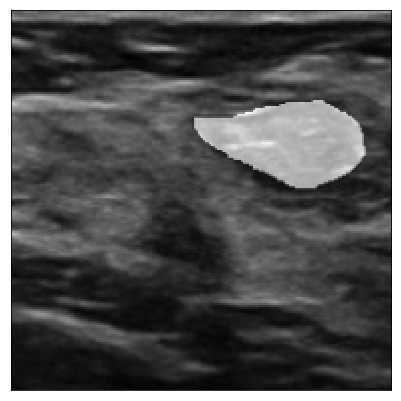

預測的位置與BI-RYAS:  [3 2 2]


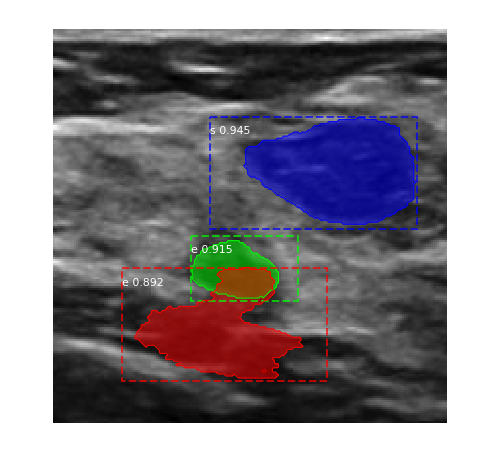

[[ 42  76  97 177]
 [100  67 132 119]
 [116  33 171 133]]
[2 1 1]
[0.94477767 0.9150426  0.8915022 ]


In [44]:
test_data_set = BreastUltrasoundDataset()
test_data_set.inital_dataset(TEST_IMAGE_DIR)
test_data_set.prepare()

image_id=np.random.choice(test_data_set.image_ids, 1)[0]
print (image_id)

image = test_data_set.load_image(image_id) 
bi_rays, image_path = test_data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))

results = model.detect([image], verbose=1)


bi_rays, image_path = test_data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))
print ('實際的位置與BI-RYAS :',bi_rays+1)
display_mixed_image(image_path, 192, 192)

r = results[0]
print ('預測的位置與BI-RYAS: ', r['class_ids']+1)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           'test', r['scores'], figsize=(8, 8) ) #ax=get_ax()

print ( r['rois'])
print (r['class_ids'])
print (r['scores'])
 
roi_foure = results[0]

In [45]:
 TEST_IMAGE_DIR = os.path.join(ROOT_DIR, "images/test")
print ('Test IMAGE DIR : ', TEST_IMAGE_DIR )

test_data_set = BreastUltrasoundDataset()
test_data_set.inital_dataset(TEST_IMAGE_DIR)
test_data_set.prepare()

img_len = len(test_data_set.image_ids)
#img_len = 1
print (img_len)
image_ids = np.random.choice(test_data_set.image_ids, img_len)
#print (image_ids)
APs = []
BI_RADS3=[]
BI_RADS2=[]
BI_RADS4=[]
low_threashold_2=[]
low_threashold_3=[]
low_threashold_4=[]

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(test_data_set, config2,
                               image_id, use_mini_mask=False)
    
    #molded_images = np.expand_dims(modellib.mold_image(image, config2), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks']) 
   # print (AP, precisions, recalls, overlaps)

    #visualize.plot_precision_recall(AP, precisions, recalls)

    if gt_class_id == 1:
        BI_RADS2.append(AP)
    elif gt_class_id == 2:
        BI_RADS3.append(AP)
    elif gt_class_id == 3:
        BI_RADS4.append(AP)
            
    if AP < 0.7:
        if gt_class_id == 1:
            low_threashold_2.append((image_id, AP))      
        elif gt_class_id == 2:
            low_threashold_3.append((image_id, AP))      
        elif gt_class_id == 3:
            low_threashold_4.append((image_id,AP))  
  
    APs.append(AP)
    
print("Total mAP: ", np.mean(APs), np.max(APs), np.min(APs))
#print (BI_RADS2)
print("BI_RADS2 mAP: ", len(BI_RADS2) , np.mean(BI_RADS2), np.max(BI_RADS2), np.min(BI_RADS2))

print (BI_RADS3)
print("BI_RADS3 mAP: ", len(BI_RADS3) , np.mean(BI_RADS3), np.max(BI_RADS3), np.min(BI_RADS3))

print (BI_RADS4)
print("BI_RADS4 mAP: ", len(BI_RADS4), np.mean(BI_RADS4), np.max(BI_RADS4), np.min(BI_RADS4))


Test IMAGE DIR :  C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\2
BI-RAYS:2 Image Count:159
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\3
BI-RAYS:3 Image Count:122
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\4
BI-RAYS:4 Image Count:35
316
[215 299 315 149 220 153 136 120  65 280  10 280  70 244 253 160  73 270
 154  67  49 116 123 242 202 149 104  19 100 198 187 284 241   0 122  31
 247  50 110 223 100 121 170 275 217 146  64 282 271 185 238 165 257 127
 242  16 302  42 113 274 261 272 261 121  27   1 262 148 256 214 165 280
  56 169 263 288 306  97  36  73  47 173 192 180 244 246  79 275  86 156
   5  49 147 168 219  96 237  10 280  46  56 278  94 209 291  40 231 235
  70 216  30 160 126 179 124 246 281 215 161 315 292 301 146 143 125 304
 288 313 273 102  10 298 227  15  20 114   5 239 218   2  27 170 153 182
 185 264 206 237  66  18 118  10 224  19 219 220 261  63  75 158 293  76
 197 258 102 307 276 259  87 2